In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import json
import seaborn as sns
from datetime import datetime
# from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
import re

In [2]:
#Load kinematics data
from tongue_kinematics_utils import load_keypoints_from_csv
keypoint_dfs = load_keypoints_from_csv('/root/capsule/data/matt_test_DLC_LP_results_20240920/outputs/video_preds3/bottom_camera.csv')
print(keypoint_dfs.keys())
# keypoint_dfs

#get original video csv
video_csv = pd.read_csv('/root/capsule/data/behavior_716325_2024-05-31_10-31-14/behavior-videos/bottom_camera.csv', names = ['Behav_Time','Frame','Camera_Time','Gain','Exposure'])

#assert timebase
def trim_kinematics_timebase_to_match(keypoint_dfs,video_csv):
    """
    trims lightning pose keypoints dataframe OR video csv timebase array to match in length for further processing
    NB: ASSUMES both data structures start at beginning and are aligned-- requires QC
    TODO: figure out why video has one more frame than lightningpose csv file

    Parameters:
    - keypoint_dfs: dataframe from load_keypoints_from_csv
    - video_csv: csv file from original bonsai video acquisition

    Returns:
    - keypoint_dfs_trimmed: trimmed if longer than video_csv, otherwise unchanged
    - video_csv_trimmed: timebase for kinematics data, in time aligned to nwb time. trimmed if longer than keypoint_dfs
    """

    LP_samples = len(keypoint_dfs[list(keypoint_dfs.keys())[0]])
    video_samples = len(video_csv)
    min_samples = np.min([LP_samples,video_samples])

    video_csv_trimmed = video_csv.iloc[:min_samples]
    keypoint_dfs_trimmed = keypoint_dfs.copy()
    for key in keypoint_dfs.keys():
        keypoint_dfs_trimmed[key] = keypoint_dfs[key].iloc[:min_samples]
    
    return keypoint_dfs_trimmed, video_csv_trimmed
keypoint_dfs_trimmed, video_csv_trimmed = trim_kinematics_timebase_to_match(keypoint_dfs,video_csv)
keypoint_timebase = video_csv_trimmed['Behav_Time']


/root/capsule/code/tongue_kinematics_utils.py:217: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_csv)


dict_keys(['nose_tip', 'tongue_tip', 'jaw', 'pointer_finger_l', 'pointer_finger_r', 'spout_l', 'spout_r'])


In [3]:
#extract tongue dataframe and mask
from tongue_kinematics_utils import mask_keypoint_data
tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip',confidence_threshold=0.8)
tongue_masked.insert(0,'time',keypoint_timebase-keypoint_timebase[0])


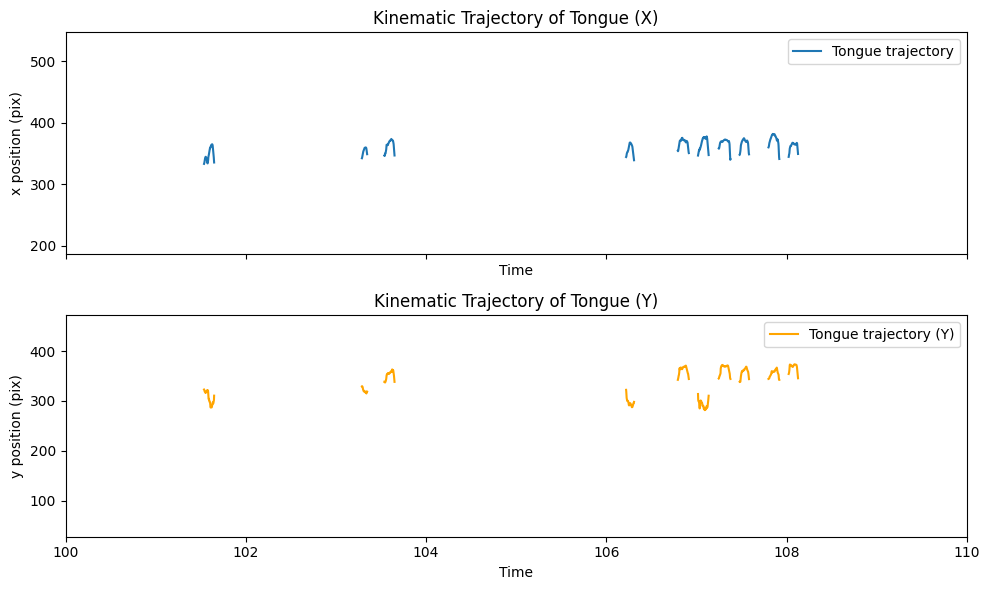

In [4]:
# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 6),sharex=True)

# First subplot
axs[0].plot(tongue_masked['time'], tongue_masked['x'], linestyle='-', label='Tongue trajectory')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('x position (pix)')
axs[0].set_title('Kinematic Trajectory of Tongue (X)')
axs[0].legend()

# Second subplot
axs[1].plot(tongue_masked['time'], tongue_masked['y'], linestyle='-', label='Tongue trajectory (Y)', color='orange')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('y position (pix)')
axs[1].set_title('Kinematic Trajectory of Tongue (Y)')
axs[1].legend()

time_len = 10
start_time = 100

plt.setp(axs,xlim = [tongue_masked['time'][0]+start_time, tongue_masked['time'][0]+start_time+time_len])
# Adjust layout
plt.tight_layout()
plt.show()


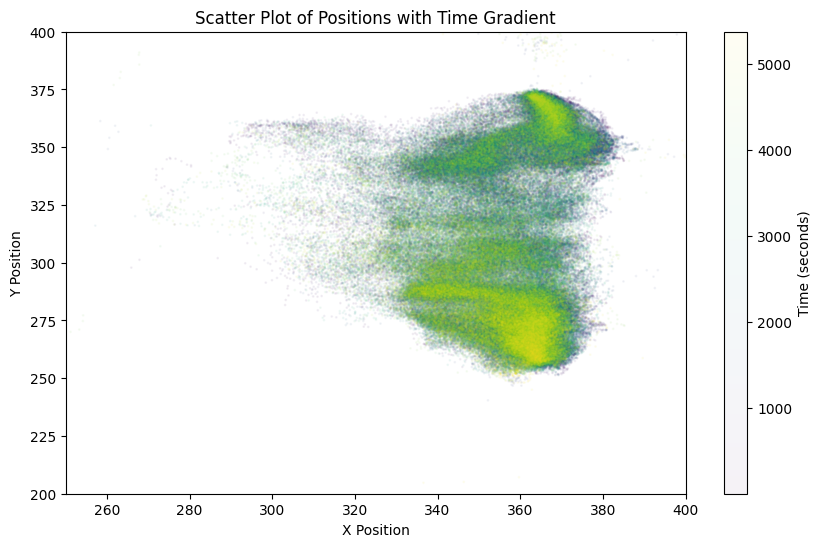

In [5]:
# Create scatter plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(tongue_masked['x'], tongue_masked['y'], c=tongue_masked['time'], cmap='viridis', s=1, alpha=0.05)
plt.colorbar(sc, label='Time (seconds)')
plt.title('Scatter Plot of Positions with Time Gradient')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.xlim(250,400)
plt.ylim(200,400)
plt.show()

In [6]:
# plt.figure(figsize=(10, 6))
# ax_kde = sns.kdeplot(x=tongue_masked['x'], y=tongue_masked['y'], cmap='viridis', fill=True, thresh=0, levels=30)
# plt.title('Heatmap of Positions')
# plt.xlabel('X Position')
# plt.ylabel('Y Position')
# plt.xlim(250,400)
# plt.ylim(200,400)

# # with spouts
# spoutR = np.mean(keypoint_dfs_trimmed['spout_l'][['x', 'y']],0)
# spoutL = np.mean(keypoint_dfs_trimmed['spout_r'][['x', 'y']],0)
# plt.scatter(spoutR['x'],spoutR['y'], c = 'red', s = 40)
# plt.scatter(spoutL['x'],spoutL['y'], c = 'blue', s = 40)

# plt.show()

In [7]:
import scipy
from scipy.signal import butter, filtfilt, sosfiltfilt

def kinematics_filter(df, frame_rate = 500, cutoff_freq = 20):
    # Ensure the DataFrame has the required columns
    required_columns = ['time', 'x', 'y']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Input DataFrame must contain the columns: {required_columns}")

    # Generate new timestamps for interpolation
    # 1. fills in missing timestamps if dropped frames
    # 2. makes sure timestamps are evenly spaced
    t = df['time'].values
    dt = np.diff(t)
    new_ts = []

    for num in range(len(dt)):
        tspace = dt[num] / (1/frame_rate)
        intgr = int(np.floor(tspace))
        if intgr >= 2:
            new_t = np.linspace(t[num], t[num + 1], intgr)
            new_ts.extend(new_t)

    new_t = np.unique(np.concatenate((t, new_ts)))

    # Interpolate the data using np.interp
    # remove NaN for interpolation
    x_nonan = df['x'][df['x'].notna()].values
    y_nonan = df['y'][df['y'].notna()].values
    t_nonan = df['time'][df['x'].notna()].values


    x = np.interp(new_t, t_nonan, x_nonan)
    y = np.interp(new_t, t_nonan, y_nonan)

    intrp = pd.DataFrame({'time': new_t, 'x': x, 'y': y})

    # Get the velocity
    times = intrp['time'].values
    t_diff = np.gradient(times)

    xv = np.gradient(intrp['x'].values) / t_diff
    yv = np.gradient(intrp['y'].values) / t_diff
    v = np.sqrt(xv**2 + yv**2) #speed

    intrp['v'] = v
    intrp['xv'] = xv
    intrp['yv'] = yv

    # Filter the data (cutoff: fc / (fs / 2))
    cutoff = cutoff_freq / (frame_rate / 2)
    b, a = butter(1, cutoff)

    filtered_values = filtfilt(b, a, intrp[['x', 'y', 'v', 'xv', 'yv']].values, axis=0)


    filtered_df = pd.DataFrame(filtered_values, columns=['x', 'y', 'v', 'xv', 'yv'])
    filtered_df.insert(0,'time',intrp['time'].values)

    # Keep data only at real points
    df_temp = df.reindex(columns = list(filtered_df.columns.tolist())) #get new columns
    df_nonan_index = df['time'][df['x'].notna()].index.tolist() #index of nonans in original df
    filtered_df_nonan_index = filtered_df[filtered_df['time'].isin(t_nonan)].index.tolist() #index of matching timepoints in new df

    df_temp.iloc[df_nonan_index] = filtered_df.iloc[filtered_df_nonan_index]

    keypoint_filtered = df_temp

    return keypoint_filtered.reset_index(drop=True)

# Assuming 'tongue_masked' is defined elsewhere
tongue_filtered = kinematics_filter(tongue_masked,cutoff_freq=50)


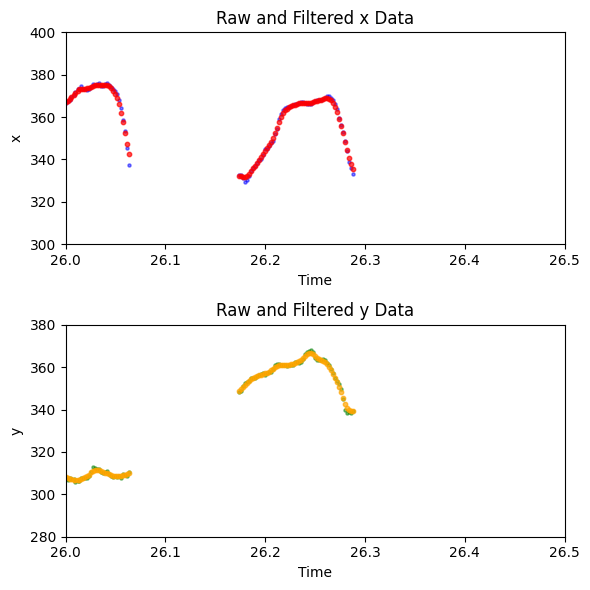

In [8]:
df = tongue_masked
df_filtered = tongue_filtered

# Define your desired x-axis limits
x_limits = (tongue_masked['time'][0]+26, tongue_masked['time'][0]+26.5)  # Replace with your desired limits, e.g., (2, 5)

# Plotting for 'x'
plt.figure(figsize=(6, 6))

plt.subplot(2, 1, 1)
plt.scatter(df['time'], df['x'], label='Raw x', color='blue', alpha=0.5, s=5)  # Raw data
plt.scatter(df_filtered['time'], df_filtered['x'], label='Filtered x', color='red', alpha=0.7, s=10)  # Filtered data
plt.title('Raw and Filtered x Data')
plt.xlabel('Time')
plt.ylabel('x')
plt.xlim(x_limits)  # Set x-axis limits
plt.ylim([300, 400])

# Plotting for 'y'
plt.subplot(2, 1, 2)
plt.scatter(df['time'], df['y'], label='Raw y', color='green', alpha=0.5, s=5)  # Raw data
plt.scatter(df_filtered['time'], df_filtered['y'], label='Filtered y', color='orange', alpha=0.7, s=10)  # Filtered data
plt.title('Raw and Filtered y Data')
plt.xlabel('Time')
plt.ylabel('y')
plt.xlim(x_limits)  # Set x-axis limits
plt.ylim([280, 380])


plt.tight_layout()
plt.show()


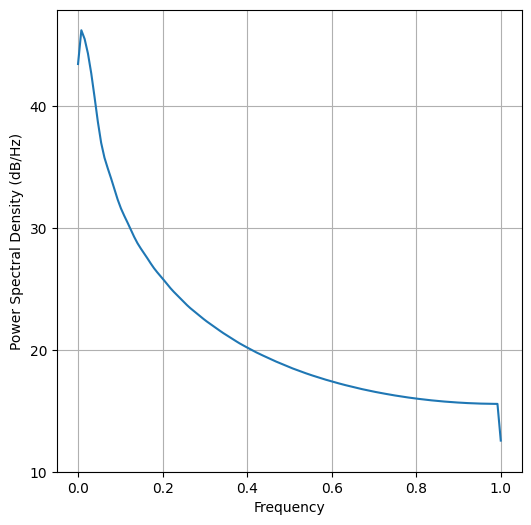

In [9]:
plt.figure(figsize=(6, 6))
plt.psd(df_filtered['x'].values[1050:1100])
plt.show()

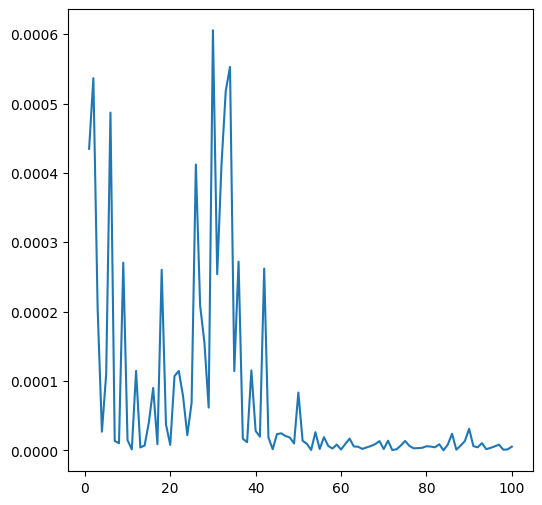

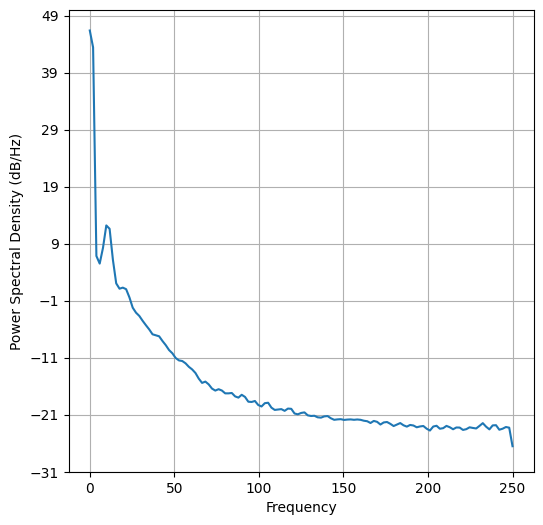

In [10]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Filter out NaN values from the time and x data
time_filtered = df_filtered['time']
x_filtered = df_filtered['x']

# Mask NaN values
mask = ~np.isnan(time_filtered) & ~np.isnan(x_filtered)
time_filtered = time_filtered[mask]
x_filtered = x_filtered[mask]

# Set up the frequency range
w = np.linspace(1, 100, 100)

# Compute the Lomb-Scargle periodogram
pgram = signal.lombscargle(time_filtered, x_filtered, w, normalize=True)

# Plot the result
plt.figure(figsize=(6, 6))
plt.plot(w, pgram)
plt.show()



#check out normal psd (although not sure if it is valid due to uneven sampling)
plt.figure(figsize=(6, 6))
plt.psd(x_filtered,Fs=500)
plt.show()

In [11]:
# def segment_movements(df, max_dropped_frames=3):
#     segments = []
#     current_segment = []
#     nan_counter = 0
    
#     for i, row in df.iterrows():
#         if pd.isna(row['x']) or pd.isna(row['y']):  # Object not detected
#             nan_counter += 1
#         else:  # Object detected
#             nan_counter = 0
            
#         if nan_counter <= max_dropped_frames:  # Allowable dropped frames
#             current_segment.append(row)
#         else:
#             if current_segment:  # Save the current segment
#                 segments.append(pd.DataFrame(current_segment))
#                 current_segment = []  # Start a new segment
                
#     # Add last segment if any
#     if current_segment:
#         segments.append(pd.DataFrame(current_segment))
    
#     return segments

# movements = segment_movements(tongue_filtered, max_dropped_frames=3)


In [12]:

def segment_movements(df, max_dropped_frames=3):
    segments = []
    current_segment = []
    nan_counter = 0
    
    for i, row in df.iterrows():
        if pd.isna(row['x']) or pd.isna(row['y']):  # Object not detected
            nan_counter += 1
        else:  # Object detected
            nan_counter = 0
            
        if nan_counter <= max_dropped_frames:  # Allowable dropped frames
            current_segment.append(row)
        else:
            if current_segment:  # Save the current segment if not empty
                segment_df = pd.DataFrame(current_segment)
                
                # Check if all values (except time) are NaN
                if not segment_df[['x', 'y', 'xv', 'yv', 'v']].isna().all().all():
                    # Trim only leading and trailing NaNs
                    first_valid_idx = segment_df[['x', 'y']].notna().idxmax().min()
                    last_valid_idx = segment_df[['x', 'y']].notna()[::-1].idxmax().min()
                    trimmed_segment_df = segment_df.loc[first_valid_idx:last_valid_idx].reset_index(drop=True)
                    
                    segments.append(trimmed_segment_df)
                
                current_segment = []  # Start a new segment
    
    # Add last segment if any and trim it
    if current_segment:
        segment_df = pd.DataFrame(current_segment)
        
        if not segment_df[['x', 'y', 'xv', 'yv', 'v']].isna().all().all():
            first_valid_idx = segment_df[['x', 'y']].notna().idxmax().min()
            last_valid_idx = segment_df[['x', 'y']].notna()[::-1].idxmax().min()
            trimmed_segment_df = segment_df.loc[first_valid_idx:last_valid_idx].reset_index(drop=True)
            segments.append(trimmed_segment_df)
    
    return segments


movements = segment_movements(tongue_filtered, max_dropped_frames=3)



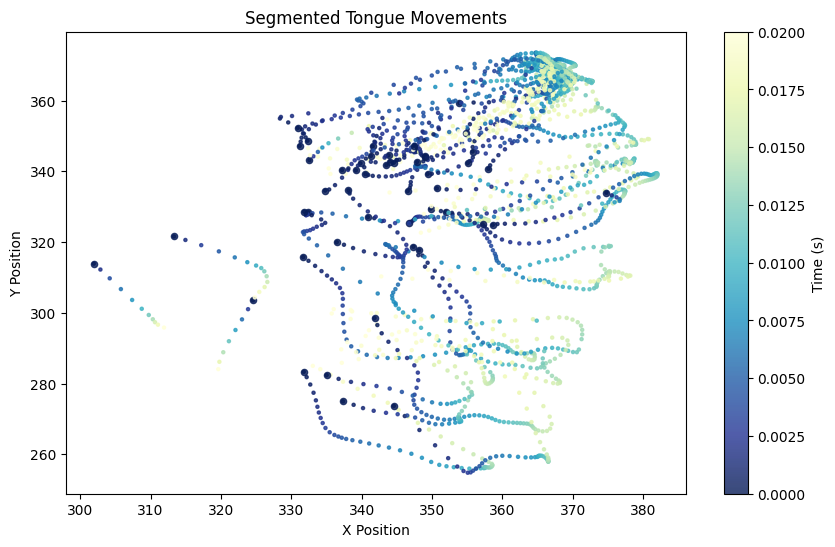

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_segmented_movements_global_time_colored(segments):
    plt.figure(figsize=(10, 6))
    
    # Find global minimum and maximum time for consistent color mapping
    all_times = pd.concat([segment['time'] for segment in segments])
    global_min_time = all_times.min()
    global_max_time = all_times.max()

    for i, segment in enumerate(segments):
        if not segment['x'].empty:
            # Normalize time based on the global min and max
            norm_time = (segment['time'] - global_min_time) / (global_max_time - global_min_time)
            norm_time = segment['time'] - segment['time'][0]
            
            # Mark start point of each segment
            plt.scatter(segment['x'].iloc[0], segment['y'].iloc[0], c = norm_time[0], cmap='YlGnBu_r', s=20, alpha=0.8)

            # Plot each segment with color gradient based on actual time
            plt.scatter(segment['x'], segment['y'], c=norm_time, cmap='YlGnBu_r', s=5,alpha = 0.8)

            
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.colorbar(label='Time (s)')
    plt.title('Segmented Tongue Movements')
    plt.show()

# Example usage
# Call plot_segmented_movements_global_time_colored on the list of segments from segment_movements function
plot_segmented_movements_global_time_colored(movements[0:50])


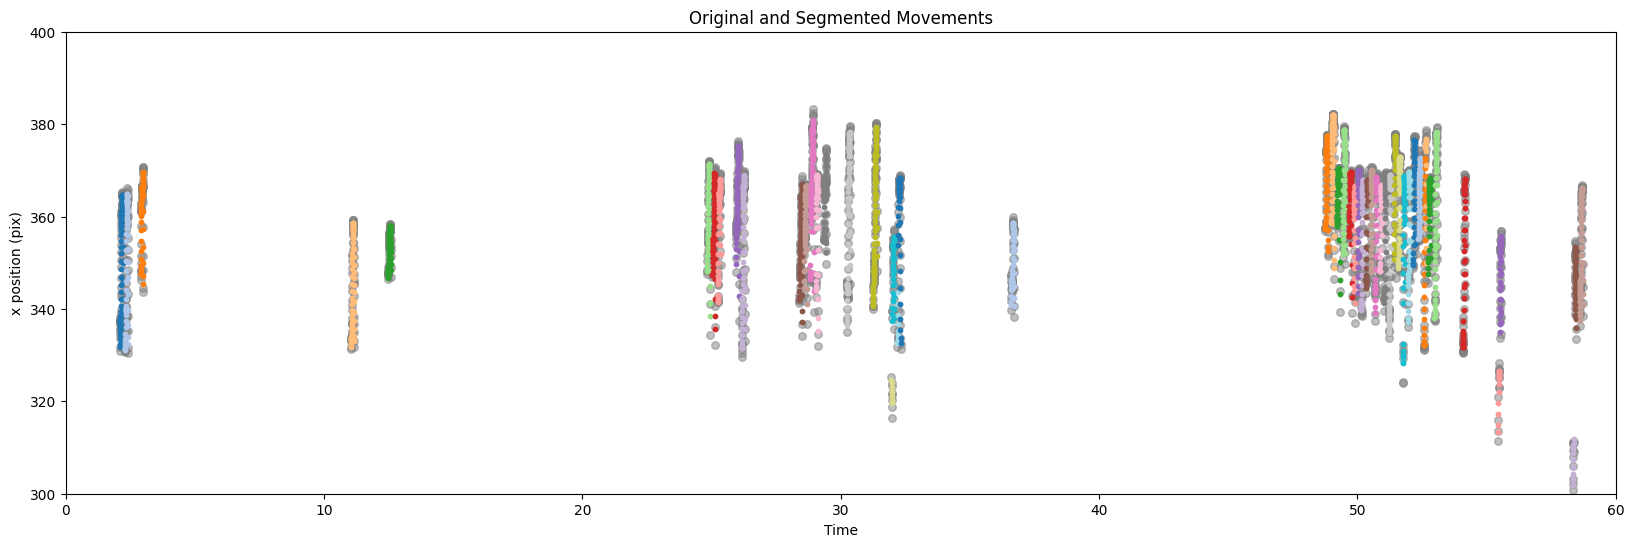

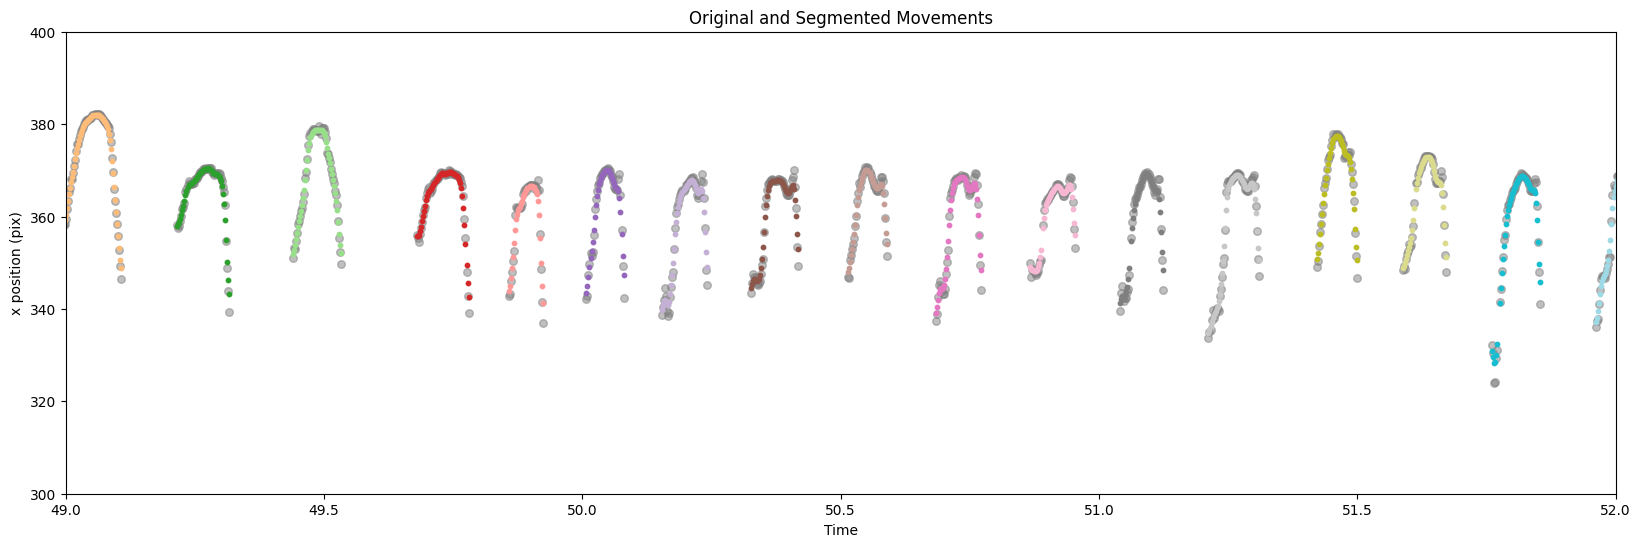

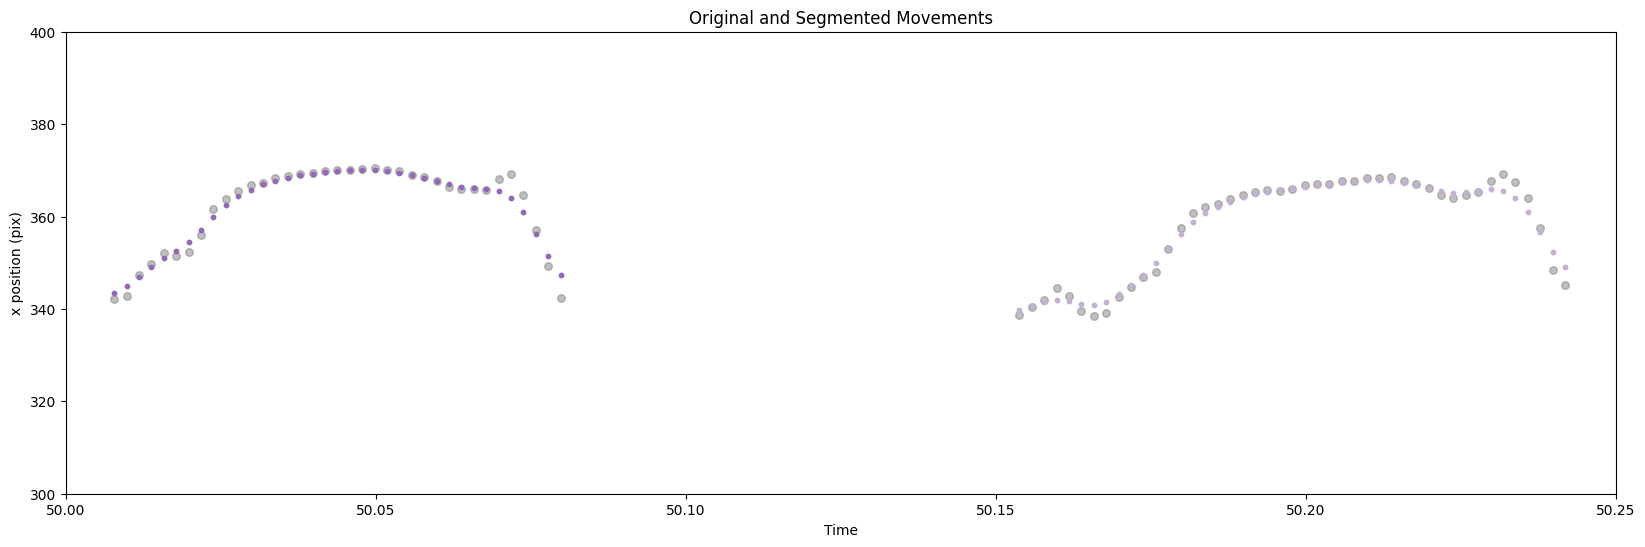

In [14]:

# Function to plot original and segmented data with a categorical colormap
def plot_original_and_segmented_data(original_data, segments, xlim=None):
    plt.figure(figsize=(20, 6))

    # Plot original data
    plt.scatter(original_data['time'], original_data['x'], color='gray', s=30, label='Original Data', alpha=0.5)

    # Use 'tab20' colormap for distinct segment colors
    colors = plt.cm.tab20(np.arange(len(segments)) % 20)  # Cycle colors if more than 20 segments

    for i, segment in enumerate(segments):
        plt.scatter(segment['time'], segment['x'], color=colors[i], s=10)
    
    # Labels and legend
    plt.xlabel('Time')
    plt.ylabel('x position (pix)')
    plt.title('Original and Segmented Movements')
    
    if xlim is not None:
        plt.xlim(xlim)
    else:
        plt.xlim([0, segments[-1]['time'].values[-1]])

    plt.ylim([300,400])
    
    plt.show()


# Example usage
# Call plot_original_and_segmented_data with your original data and segments
plot_original_and_segmented_data(tongue_masked, movements[0:70],[0,60])
plot_original_and_segmented_data(tongue_masked, movements[0:70],[49,52])
plot_original_and_segmented_data(tongue_masked, movements[0:70],[50,50.25])


In [15]:
pip install aind_dynamic_foraging_data_utils

Note: you may need to restart the kernel to use updated packages.


In [16]:
from aind_dynamic_foraging_data_utils import nwb_utils


# get list of available sessions
file_pattern = "*.nwb"
nwb_folder = "/root/capsule/data/foraging_nwb_bonsai"
file_list = glob.glob(os.path.join(nwb_folder + "/" + file_pattern))
file_names = [os.path.basename(file) for file in file_list]
# file_name = file_names[20]

def parseSessionID(file_name):
    if len(re.split('[_.]', file_name)[0]) == 6:
        aniID = re.split('[_.]', file_name)[0]
        date = re.split('[_.]', file_name)[1]
        dateObj = datetime.strptime(date, "%Y-%m-%d")
    else:
        aniID = None
        dateObj = None
    
    return aniID, dateObj
    
results = [parseSessionID(file_name) for file_name in file_names]
aniIDs, dates = zip(*results)

sessionInfo = pd.DataFrame({'sessionID': file_names,
                            'aniID': aniIDs,
                            'date': dates})
#select animal
anim_name = '716325'
anim_inx = sessionInfo['aniID'] == anim_name
sessionInfo_anim = sessionInfo[anim_inx]
# sessionInfo_anim

#select date
session_date = '05-31-2024'
date_inx = sessionInfo_anim['date'] == session_date
sessionInfo_anim_date = sessionInfo_anim[date_inx]
# sessionInfo_anim_date
#get nwb
session_id = sessionInfo_anim_date['sessionID'].values[0]

nwb_folder = "/root/capsule/data/foraging_nwb_bonsai"
nwb_file = f"{nwb_folder}/{session_id}"
nwb = nwb_utils.load_nwb_from_filename(nwb_file)


nwb.df_trials = nwb_utils.create_df_trials(nwb)


/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


In [17]:
pip install git+https://github.com/AllenNeuralDynamics/aind-dynamic-foraging-basic-analysis@main

  Cloning https://github.com/AllenNeuralDynamics/aind-dynamic-foraging-basic-analysis (to revision main) to /tmp/pip-req-build-g831nn3c
  Running command git clone -q https://github.com/AllenNeuralDynamics/aind-dynamic-foraging-basic-analysis /tmp/pip-req-build-g831nn3c
  Resolved https://github.com/AllenNeuralDynamics/aind-dynamic-foraging-basic-analysis to commit d98625ff5109386c1685bfe3795c2439bf9d62a9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Note: you may need to restart the kernel to use updated packages.


In [18]:
nwb.df_events = nwb_utils.create_events_df(nwb)
nwb.df_events['time_video'] = nwb.df_events['raw_timestamps']-keypoint_timebase[0]
nwb.df_events.head(20)

Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


,timestamps,data,event,raw_timestamps,trial,time_video
0,-46.419808,1.0,left_lick_time,3.892924e+06,0,2.157728
1,-46.225664,1.0,right_lick_time,3.892925e+06,0,2.351872
2,-45.653856,1.0,right_lick_time,3.892925e+06,0,2.923680
3,-37.471392,1.0,left_lick_time,3.892933e+06,0,11.106144
4,-23.490432,1.0,left_lick_time,3.892947e+06,0,25.087104
5,-23.309888,1.0,right_lick_time,3.892948e+06,0,25.267648
6,-22.363936,1.0,right_lick_time,3.892949e+06,0,26.213600
7,-20.137632,1.0,left_lick_time,3.892951e+06,0,28.439904
8,-19.975648,1.0,left_lick_time,3.892951e+06,0,28.601888
9,-19.734080,1.0,right_lick_time,3.892951e+06,0,28.843456


In [19]:
df_events_lick = nwb.df_events[nwb.df_events['event'].isin(['left_lick_time', 'right_lick_time'])]

def match_licks_to_movements(df_events, movement_dfs):
    movement_counter = 0  # Pointer to track current movement index
    df_events = df_events.copy()  # Avoid modifying original DataFrame

    # Initialize new columns for storing movement features
    df_events['matched_movement_index'] = None
    
    for i in df_events.index:
        t_vid = df_events.loc[i, 'time_video']

        # Move forward in movement list until we find a potential match
        while movement_counter < len(movement_dfs):
            movement_df = movement_dfs[movement_counter]
            t_start = movement_df['time'].min()
            t_end = movement_df['time'].max()

            if t_end < t_vid:
                # Movement is entirely before the lick time, move forward
                movement_counter += 1
            elif t_start <= t_vid <= t_end:
                # Found a match, extract kinematics
                df_events.at[i, 'matched_movement_index'] = movement_counter
                
                break  # Stop searching once a match is found
            else:
                # If the movement starts after the lick time, no need to check further
                break

    return df_events

df_events_lick = match_licks_to_movements(df_events_lick,movements)
nwb.df_events.loc[df_events_lick.index, 'matched_movement_index'] = df_events_lick['matched_movement_index']
nwb.df_events.head(20)


,timestamps,data,event,raw_timestamps,trial,time_video,matched_movement_index
0,-46.419808,1.0,left_lick_time,3.892924e+06,0,2.157728,0
1,-46.225664,1.0,right_lick_time,3.892925e+06,0,2.351872,1
2,-45.653856,1.0,right_lick_time,3.892925e+06,0,2.923680,2
3,-37.471392,1.0,left_lick_time,3.892933e+06,0,11.106144,3
4,-23.490432,1.0,left_lick_time,3.892947e+06,0,25.087104,6
5,-23.309888,1.0,right_lick_time,3.892948e+06,0,25.267648,7
6,-22.363936,1.0,right_lick_time,3.892949e+06,0,26.213600,9
7,-20.137632,1.0,left_lick_time,3.892951e+06,0,28.439904,10
8,-19.975648,1.0,left_lick_time,3.892951e+06,0,28.601888,11
9,-19.734080,1.0,right_lick_time,3.892951e+06,0,28.843456,12


In [ ]:
from aind_dynamic_foraging_basic_analysis import licks

# nwb.df_licks = annotation.
# nwb.df_licks.head(20)

SyntaxError: invalid syntax (2599643420.py, line 1)

In [ ]:
#get first licks

df = nwb.df_events.copy()
# Assuming df is your dataframe
goCue_indices = df[df['event'] == 'goCue_start_time'].index  # Get indices of goCue_start_time
lick_indices = df[df['event'].isin(['left_lick_time', 'right_lick_time'])].index  # Get indices of lick events

# Find first lick index after each goCue
first_lick_indices = []
for goCue_idx in goCue_indices:
    next_licks = lick_indices[lick_indices > goCue_idx]  # Get lick indices after goCue
    if not next_licks.empty:
        first_lick_indices.append(next_licks[0])  # Store the first one

first_licks_df = df.iloc[first_lick_indices]


In [ ]:
df_trials.columns


Index(['trial', 'animal_response', 'rewarded_historyL', 'rewarded_historyR',
       'bait_left', 'bait_right', 'base_reward_probability_sum',
       'reward_probabilityL', 'reward_probabilityR',
       'reward_random_number_left', 'reward_random_number_right',
       'left_valve_open_time', 'right_valve_open_time', 'block_beta',
       'block_min', 'block_max', 'min_reward_each_block', 'delay_beta',
       'delay_min', 'delay_max', 'delay_duration', 'ITI_beta', 'ITI_min',
       'ITI_max', 'ITI_duration', 'response_duration',
       'reward_consumption_duration', 'reward_delay', 'auto_waterL',
       'auto_waterR', 'laser_on_trial', 'laser_wavelength', 'laser_location',
       'laser_1_power', 'laser_2_power', 'laser_on_probability',
       'laser_duration', 'laser_condition', 'laser_condition_probability',
       'laser_start', 'laser_start_offset', 'laser_end', 'laser_end_offset',
       'laser_protocol', 'laser_frequency', 'laser_rampingdown',
       'laser_pulse_duration', 'session

In [ ]:
first_licks_df.head(20)

,timestamps,data,event,raw_timestamps,trial,time_video,matched_movement_index
14,0.660256,1.0,right_lick_time,3.892972e+06,0,49.237792,24
37,13.692288,1.0,right_lick_time,3.892985e+06,1,62.269824,53
73,30.028992,1.0,right_lick_time,3.893001e+06,2,78.606528,98
118,64.078976,1.0,right_lick_time,3.893035e+06,3,112.656512,155
167,136.896288,1.0,right_lick_time,3.893108e+06,4,185.473824,242
170,142.472736,1.0,right_lick_time,3.893113e+06,5,191.050272,246
177,150.077376,1.0,right_lick_time,3.893121e+06,6,198.654912,256
195,154.958912,1.0,right_lick_time,3.893126e+06,7,203.536448,274
225,170.600032,1.0,right_lick_time,3.893141e+06,8,219.177568,313
247,177.223104,1.0,right_lick_time,3.893148e+06,9,225.800640,335
